# tf.dataを使って画像をロードする

このチュートリアルでは、`tf.data`を使って画像データをロードする。

このチュートリアルで使用するデータセットは、クラスごとに別々のディレクトリに分かれた形で配布されている。

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

## データセットのダウンロードと検査

### 画像の取得

訓練を始める前に、ネットワークに認識するべき新しいクラスを教えるために画像のセットが必要。
最初に使うためのクリエイティブ・コモンズでライセンスされた花の画像のアーカイブを作成してある。

In [3]:
import pathlib
data_root_orig = tf.keras.utils.get_file(origin="https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz",
                                         fname="flower_photos", untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

C:\Users\ognek\.keras\datasets\flower_photos


ダウンロードが完了すると、花の画像のコピーが使えるようになっている。

In [4]:
for item in data_root.iterdir():
    print(item)

C:\Users\ognek\.keras\datasets\flower_photos\daisy
C:\Users\ognek\.keras\datasets\flower_photos\dandelion
C:\Users\ognek\.keras\datasets\flower_photos\LICENSE.txt
C:\Users\ognek\.keras\datasets\flower_photos\roses
C:\Users\ognek\.keras\datasets\flower_photos\sunflowers
C:\Users\ognek\.keras\datasets\flower_photos\tulips


In [5]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

3670

In [6]:
all_image_paths[:10]

['C:\\Users\\ognek\\.keras\\datasets\\flower_photos\\tulips\\2535936698_78cc03df3f_n.jpg',
 'C:\\Users\\ognek\\.keras\\datasets\\flower_photos\\sunflowers\\23247483352_0defc7a6dc_n.jpg',
 'C:\\Users\\ognek\\.keras\\datasets\\flower_photos\\dandelion\\13807932364_673b7f1c1c_n.jpg',
 'C:\\Users\\ognek\\.keras\\datasets\\flower_photos\\tulips\\16309287412_5cc4d58bd1_n.jpg',
 'C:\\Users\\ognek\\.keras\\datasets\\flower_photos\\tulips\\4945315538_97bdd873c4.jpg',
 'C:\\Users\\ognek\\.keras\\datasets\\flower_photos\\roses\\4881402397_1c664af2f7_n.jpg',
 'C:\\Users\\ognek\\.keras\\datasets\\flower_photos\\daisy\\20685027271_0e7306e7c1_n.jpg',
 'C:\\Users\\ognek\\.keras\\datasets\\flower_photos\\tulips\\107693873_86021ac4ea_n.jpg',
 'C:\\Users\\ognek\\.keras\\datasets\\flower_photos\\sunflowers\\9482209981_bf7bf6022b_m.jpg',
 'C:\\Users\\ognek\\.keras\\datasets\\flower_photos\\daisy\\2862944799_45bc8e7302.jpg']

## 画像の検査

扱っている画像について知るために、画像のいくつかを見てみる。

In [7]:
import os
attributions = (data_root/"LICENSE.txt").open(encoding="utf-8").readlines()[4:]
attributions = [line.split(" CC-BY") for line in attributions]
attributions = dict(attributions)

In [8]:
import IPython.display as display

def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    # for Windows
    image_rel = str(image_rel).replace("\\", "/")
    return "Image (CC BY 2.0) " + ' - '.join(attributions[str(image_rel)].split(' - ')[:-1])

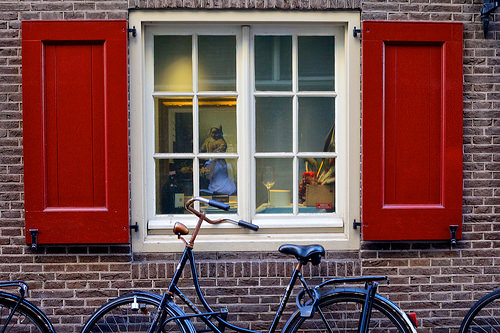

Image (CC BY 2.0)  by Francesca Cappa



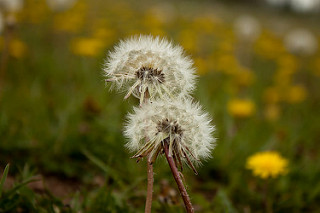

Image (CC BY 2.0)  by Shaun Fisher



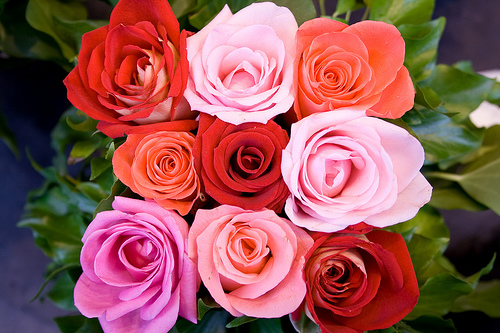

Image (CC BY 2.0)  by Rosa y Dani



In [9]:
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path))
    print(caption_image(image_path))
    print()

### 各画像のラベルの決定

まずはラベルを一覧する。

In [11]:
label_names = sorted(item.name for item in data_root.glob("*/") if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

ラベルにインデックスを割り当てる。

In [12]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [13]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [4, 3, 1, 4, 4, 2, 0, 4, 3, 0]


### 画像の読み込みと整形

TensorFlowには画像を読み込んで処理するために必要なツールが備わっている。

In [14]:
img_path = all_image_paths[0]
img_path

'C:\\Users\\ognek\\.keras\\datasets\\flower_photos\\tulips\\2535936698_78cc03df3f_n.jpg'

In [15]:
# 生データ
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00...


In [16]:
# 画像のテンソルにデコード
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(213, 320, 3)
<dtype: 'uint8'>


In [17]:
# モデルに合わせてリサイズ
img_final = tf.image.resize(img_tensor, [192, 192])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(192, 192, 3)
0.0
0.996875


In [18]:
# 関数としてまとめる
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [192, 192])
    image /= 255.0
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

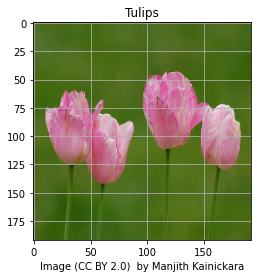

In [19]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid()
plt.xlabel(caption_image(img_path))
plt.title(label_names[label].title())
print()

## tf.data.Datasetの構築

### 画像のデータセット
`tf.data.Dataset`を構築するもっとも簡単な方法は、`from_tensor_slices`メソッドを使うこと。

文字列の配列をスライスすると、文字列のデータセットが出来上がる。

In [20]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
print(path_ds)

<TensorSliceDataset shapes: (), types: tf.string>


`preprocess_image`をファイルパスのデータセットにマップすることで、画像を実行時にロードし整形する新しいデータセットを作成する。

In [21]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

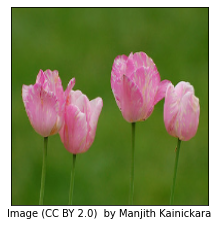

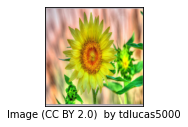

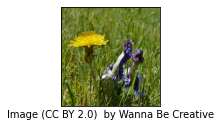

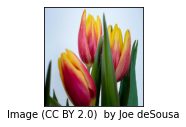

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for n, image in enumerate(image_ds.take(4)):
    plt.subplot(2, 2, n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(caption_image(all_image_paths[n]))
    plt.show()

### (image, label)のペアのデータセット

同じ`from_tensor_slices`メソッドを使ってラベルのデータセットを作ることができる。

In [23]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))
for label in label_ds.take(10):
    # print(label.numpy())
    print(label_names[label.numpy()])

tulips
sunflowers
dandelion
tulips
tulips
roses
daisy
tulips
sunflowers
daisy


これらのデータセットは同じ順番なので、zipすることで、`(image, label)`というペアのデータセットができる。

In [24]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
# 新しいデータセットのshapeとtypeは、それぞれのフィールドを示すシェイプと型のタプルになっている。
print(image_label_ds)

<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


`all_image_labels`や`all_image_paths`のような配列がある場合、上記の`tf.data.Dataset.zip`メソッドを使う代わりに、配列のペアをスライスしても作成できる。

In [25]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

# The tuples are unpacked into the positional arguments of the mapped function
# タプルは展開され、マップ関数の位置引数に割り当てられます
def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<MapDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>

### 基本的な訓練手法

このデータセットを使ってモデルの訓練を行うには、データが

- よくシャッフルされ
- バッチ化され
- 限りなく繰り返され
- バッチができるだけ早く利用できる

ことが必要。

これらの特性は、`tf.data` APIを使えば簡単に付け加えることができる。

In [26]:
BATCH_SIZE = 32

# シャッフルバッファのサイズをデータセットと同じに設定することで、データが完全にシャッフルされる
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)

# prefetchを使うことで、モデルの訓練中にバックグラウンドでデータセットがバッチを取得できる
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

これらのAPI使用時の注意点は下記。（コピペ）

1. 順番が重要です。
    - `.repeat` の前に `.shuffle` すると、エポックの境界を越えて要素がシャッフルされます。（ほかの要素がすべて出現する前に2回出現する要素があるかもしれません）
    - `.batch` の後に `.shuffle` すると、バッチの順番がシャッフルされますが、要素がバッチを越えてシャッフルされることはありません。
2. 完全なシャッフルのため、 `buffer_size` をデータセットとおなじサイズに設定しています。データセットのサイズ未満の場合、値が大きいほど良くランダム化されますが、より多くのメモリーを使用します。
3. シャッフルバッファがいっぱいになってから要素が取り出されます。そのため、大きな `buffer_size` が `Dataset`を使い始める際の遅延の原因になります。
4. シャッフルされたデータセットは、シャッフルバッファが完全に空になるまでデータセットが終わりであることを伝えません。 `.repeat` によって `Dataset` が再起動されると、シャッフルバッファが一杯になるまでもう一つの待ち時間が発生します。

最後の問題(4)は、`tf.data.Dataset.apply`メソッドを、融合された`tf.data.experimental.shuffle_and_repeat`関数と組み合わせることで対処できる。

In [27]:
ds = image_label_ds.apply(
    tf.data.experimental.shuffle_and_repeat(buffer_size=image_count)
)
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

### データセットをモデルにつなぐ

`tf.keras.applications`からMobileNet v2のコピーを取得する。

これを簡単な転移学習のサンプルに使用する。

MobileNetの重みを訓練不可に設定する。

In [28]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable=False

In [29]:
# モデルのヘルプを参照
# このモデルは、入力が[-1, 1]の範囲に正規化されていることを想定している
# help(keras_applications.mobilenet_v2.preprocess_input) # 古いコードのようで動かない

In [30]:
# データをMobileNetモデルに渡す前に、入力を[0, 1]の範囲から[-1, 1]の範囲に変換する必要がある。
def change_range(image, label):
    return 2*image-1, label

keras_ds = ds.map(change_range)

MobileNetは画像ごとに`6x6`の特徴量の空間を返す。バッチを1つ渡してみて確認する。

In [31]:
# シャッフルバッファがいっぱいになるまで、データセットは何秒かかかる
image_batch, label_batch = next(iter(keras_ds))

In [32]:
feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)

(32, 6, 6, 1280)


MobileNetをラップしたモデルを作り、出力層である`tf.keras.layers.Dense`の前に、`tf.keras.layers.GlobalAveragePooling2D`で空間の軸に沿って平均値を求める。

In [33]:
model = tf.keras.Sequential([
    mobile_net,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(label_names))
])

期待したとおりの形状の出力が得られる。

In [34]:
logit_batch = model(image_batch).numpy()

print("min logit: ", logit_batch.min())
print("max logit: ", logit_batch.max())
print()

print("Shape: ", logit_batch.shape)

min logit:  -2.827857
max logit:  2.912668

Shape:  (32, 5)


In [35]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [36]:
len(model.trainable_variables)

2

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


モデルを訓練する。

普通は、エポックごとの本当のステップ数を指定するが、ここでは3ステップだけとする。

In [38]:
steps_per_epoch = tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

115.0

In [39]:
model.fit(ds, epochs=1, steps_per_epoch=3)

Train for 3 steps
3/3 [==============================] - 10s 3s/step - loss: 7.4112 - accuracy: 0.3229


## 性能

このセクションでは、性能の向上に役立ちそうな簡単なトリックを紹介する。
詳細は、以下を参照。

[Input Pipeline Performance](https://www.tensorflow.org/guide/data_performance?hl=ja)

上記の単純なパイプラインは、エポックごとにそれぞれのファイルを一つずつ読み込む。
これは、CPUを使ったローカルでの訓練では特に問題にならないが、GPUを使った訓練では十分ではなく、いかなる分散学習でも使用するべきではない。

調査のため、まず、データセットの性能をチェックする簡単な関数を定義する。

In [40]:
import time
default_timeit_steps = 2*steps_per_epoch+1

def timeit(ds, steps=default_timeit_steps):
  overall_start = time.time()
  # Fetch a single batch to prime the pipeline (fill the shuffle buffer),
  # before starting the timer
  it = iter(ds.take(steps+1))
  next(it)

  start = time.time()
  for i,(images,labels) in enumerate(it):
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))
  print("Total time: {}s".format(end-overall_start))

現在のデータセットの性能を計測

In [40]:
ds = image_label_ds.apply(
    tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

In [41]:
timeit(ds)

........................
231.0 batches: 14.214526176452637 s
520.03140 Images/s
Total time: 20.799184322357178s


### キャッシュ

`tf.data.Dataset.cache`を使うと、エポックを超えて計算結果を簡単にキャッシュできる。
特に、データがメモリに収まるときには効果的。

ここでは、画像が前処理(デコードとリサイズ)された後で、キャッシュされる。

In [42]:
ds = image_label_ds.cache()
ds = ds.apply(
    tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

In [43]:
timeit(ds)

........................
231.0 batches: 1.4500412940979004 s
5097.78586 Images/s
Total time: 7.742120981216431s


メモリキャッシュを使う際の欠点のひとつは、実行の都度キャッシュを再構築しなければならないこと。
このため、データセットがスタートするたびに、同じだけ起動のための遅延が発生する。

In [44]:
timeit(ds)

........................
231.0 batches: 1.4946906566619873 s
4945.50492 Images/s
Total time: 1.5156347751617432s


データがメモリに収まらない場合には、キャッシュファイルを使用する。

In [45]:
ds = image_label_ds.cache(filename="./cache.tf-data")
ds = ds.apply(
    tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE).prefetch(1)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

In [46]:
timeit(ds)

........................
231.0 batches: 6.207184791564941 s
1190.87803 Images/s
Total time: 9.809687852859497s


キャッシュファイルには、キャッシュを再構築することなくデータセットを再起動できるという利点もある。
2回目が速いことを確認する。

In [47]:
timeit(ds)

........................
231.0 batches: 5.178164482116699 s
1427.53287 Images/s
Total time: 7.304882526397705s


### TFRecordファイル

#### 生の画像データ

TFRecordファイルは、バイナリの大きなオブジェクトのシーケンスを保存するための単純なフォーマット。
複数のサンプルを同じファイルに詰め込むことで、TensorFlowは複数のサンプルを一度に読み込むことができる。
これは、特にGCSのようなリモートストレージサービスを使用する際に性能を出す上で重要。

最初に、生の画像データからTFRecordファイルを構築する。

In [41]:
image_ds = tf.data.Dataset.from_tensor_slices(all_image_paths).map(tf.io.read_file)
tfrec = tf.data.experimental.TFRecordWriter('images.tfrec')
tfrec.write(image_ds)

次に、TFRecordファイルを読み込み、以前定義した`preprocess_image`関数を使って画像のデコード/リフォーマットを行うデータセットを構築する。

In [42]:
image_ds = tf.data.TFRecordDataset("immages.tfrec").map(preprocess_image)

これを、前に定義済みのラベルデータセットとzipし、期待通りの`(image, label)`のペアを得る。

In [43]:
ds = tf.data.Dataset.zip((image_ds, label_ds))
ds = ds.apply(
    tf.data.experimental.shuffle_and_repeat(buffer_size=image_count)
)
ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int64)>

In [51]:
# メモリ不足のためか、動作停止するため、以降は実行せず。
# timeit(ds)

In [ ]:
#### シリアライズしたテンソル

前処理をTFRecordファイルに保存するには、前やったように前処理した画像のデータセットを作る

In [ ]:
paths_ds = tf.data.Dataset.from_tensor_slices(all_image_labels)
image_ds = paths_ds.map(load_and_preprocess_image)
image_ds

In [ ]:
ds = image_ds.map(tf.io.serialize_tensor)
ds

In [ ]:
tfrec = tf.data.experimental.TFRecordWriter('images.tfrec')
tfrec.write(ds)

In [ ]:
ds = tf.data.TFRecordDataset('images.tfrec')

def parse(x):
  result = tf.io.parse_tensor(x, out_type=tf.float32)
  result = tf.reshape(result, [192, 192, 3])
  return result

ds = ds.map(parse, num_parallel_calls=AUTOTUNE)
ds

In [ ]:
ds = tf.data.Dataset.zip((ds, label_ds))
ds = ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds=ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds

In [ ]:
timeit(ds)